https://stackoverflow.com/questions/34975972/how-can-i-make-a-video-from-array-of-images-in-matplotlib

In [36]:
# Complicated way to import finis if not installed

import os
import sys
finis_path = "../tp" #Folder containing finis folder
finis_abs_path = os.path.abspath(finis_path)
sys.path.append(finis_abs_path)

import finis
import numpy as np
import scipy.sparse as sp
import scipy
import pyamg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import ode, solve_ivp
from scipy.optimize import approx_fprime

%load_ext line_profiler
%matplotlib notebook

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [48]:
%matplotlib notebook
def fem_rhs(mx, my, eps=1e-4, debug=False):
    if debug:
        print("fem rhs: mx = {}. my = {}".format(mx, my))
    vertices = np.array([[0., 0], [2, 0], [2, 10], [0, 10]])
    mesh = finis.triangulate(vertices=vertices, max_area=0.05)
    fe_u = finis.fe_space(mesh, order=2, order_int=2)
    fe_p = finis.fe_space(mesh, order=1, order_int=2)
    

    inside_integ = (fe_u['integ'][:,0]-mx)**2 + (fe_u['integ'][:,1]-my)**2 <= 0.25**2
    assert np.array_equal(fe_u['integ'], fe_p['integ']), "FE Spaces not compatible"
    assert np.array_equal(fe_u['w'], fe_p['w']), "FE integration weights not compatible"
    
    
    dim_u = fe_u['dof'].shape[0]
    dim_p = fe_p['dof'].shape[0]

    assert np.array_equal(fe_u['integ'], fe_p['integ']), "FE Spaces not compatible"
    assert np.array_equal(fe_u['w'], fe_p['w']), "FE integration weights not compatible"

    # Free upper boundary
    markers = fe_u['markers']
    h_bnd = np.logical_or(fe_u['dof'][:,0] == 0, fe_u['dof'][:,0] == 2)
    not_top_bnd = fe_u['dof'][:,1] < 10.0
    markers = np.logical_and(markers, np.logical_or(h_bnd, not_top_bnd))

    # Setting up system
    f1 = lambda x,y: np.zeros_like(x)
    inside = lambda x,y: ((x-mx)**2 + (y-my)**2 <= 0.25**2).astype(np.float)
    _rho = 16.0 / np.pi - 1
    f2 = lambda x,y: -9.81*np.ones_like(x)*(1. + _rho*inside(x,y))
      

    # Construct non-dirichlet RHS
    W = sp.spdiags([fe_u['w']], [0], m=fe_u['w'].size, n=fe_u['w'].size)
    A11 = fe_u['DUX'].transpose().dot(W).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W).dot(fe_u['DUY'])
    A22 = A11
    A12 = fe_u['DUY'].transpose().dot(W).dot(fe_u['DUX'])
    A21 = A12.transpose()
    A13 = -fe_u['DUX'].transpose().dot(W).dot(fe_p['U'])
    A23 = -fe_u['DUY'].transpose().dot(W).dot(fe_p['U'])

    # Question 13 Regularizer
    w_inside = np.copy(fe_u['w'])
    w_inside[np.logical_not(inside_integ)] = 0.0
    assert fe_u['w'].shape == w_inside.shape
    assert np.allclose(np.sum(fe_u['w'][inside_integ]), np.sum(w_inside)), "Must have same sum"
    W_inside = sp.spdiags([w_inside], [0], m=w_inside.size, n=w_inside.size)
    A_inside = (1./eps)*(fe_u['DUX'].transpose().dot(W_inside).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W_inside).dot(fe_u['DUY']))
    A12i = (1./eps)*(fe_u['DUY'].transpose().dot(W_inside).dot(fe_u['DUX']))
    A21i = (1./eps)*(fe_u['DUX'].transpose().dot(W_inside).dot(fe_u['DUY']))
    A_test  = sp.bmat([[A_inside, A12i, None], [A21i, A_inside, None], [None, None, sp.coo_matrix((dim_p, dim_p))]], format='csr')
    assert np.allclose((A_test - A_test.transpose()).data / np.amax(np.abs(A_test.data)), 0), "A_test is not numerically symmetric!"
    A = sp.bmat([[A11, A12, A13], [A21, A22, A23], [A13.transpose(), A23.transpose(), None]], format='csr')
    assert np.allclose((A - A.transpose()).data / np.amax(np.abs(A.data)), 0), "A is not numerically symmetric!"

    # Construct non-dirichlet LHS
    F1int = f1(fe_u['integ'][:,0], fe_u['integ'][:,1])
    F2int = f2(fe_u['integ'][:,0], fe_u['integ'][:,1])

    _F1 = np.concatenate((
        fe_u['U'].transpose().dot(W).dot(F1int),
        fe_u['U'].transpose().dot(W).dot(F2int),
        np.zeros(dim_p, )
    ))
    F = _F1

    # Apply dirichlet boundary
    row = np.where(markers==0)[0]
    col = np.arange(row.size)
    data = np.ones((row.size, ), dtype=np.float)
    P_u = sp.csr_matrix((data, (row, col)), shape=(markers.size, row.size))
    dim_ud = P_u.shape[1]
    P = sp.bmat([[P_u, None, None], [None, P_u, None], [None, None, sp.eye(dim_p)]], format='csr')
    Ad = P.transpose().dot(A).dot(P)
    assert np.allclose((Ad - Ad.transpose()).data / np.amax(np.abs(Ad.data)), 0), "Ad is not numerically symmetric!"
    Fd = P.transpose().dot(F)

    A_test_d = P.transpose().dot(A_test).dot(P)

    # Solve
    x = sp.linalg.spsolve(Ad + A_test_d, Fd)

    # Transform back (Dirichlet)
    u_h = P.dot(x)
    u1_h = u_h[0:dim_u]
    u2_h = u_h[dim_u:2*dim_u]
    p_h = u_h[2*dim_u:]
    assert p_h.size == dim_p
    
    A_v = ((1./np.sum(w_inside))*W_inside*fe_u['U'])
    vx = np.sum(A_v.dot(u1_h))
    vy = np.sum(A_v.dot(u2_h))
    
    return np.array([vx, vy])


def fem_plot(fe_u, fe_p, u1_h, u2_h, p_h):
    shading= 'flat' # flat or gouraud
    max_u = max([
        np.amax(u1_h),
        np.amax(u2_h),
    ])
    min_u = min([
        np.amin(u1_h),
        np.amin(u2_h),
    ])

    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(1, 3, 1)
    plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u1_h, shading=shading, vmin=min_u, vmax=max_u)
    ax.set_title("U_x")
    ax.set_xlabel("x")
    plt.colorbar()

    fig.add_subplot(1, 3, 2, sharex=ax, sharey=ax)
    plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u2_h, shading=shading, vmin=min_u, vmax=max_u)
    plt.title("U_y")
    plt.xlabel("x")
    plt.colorbar()

    ax = fig.add_subplot(1, 3, 3, sharex=ax, sharey=ax)
    plt.tripcolor(fe_p['dof'][:,0], fe_p['dof'][:,1], p_h,  shading=shading)
    plt.title("P")
    plt.xlabel("x")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

### Question 12: Setup

<IPython.core.display.Javascript object>


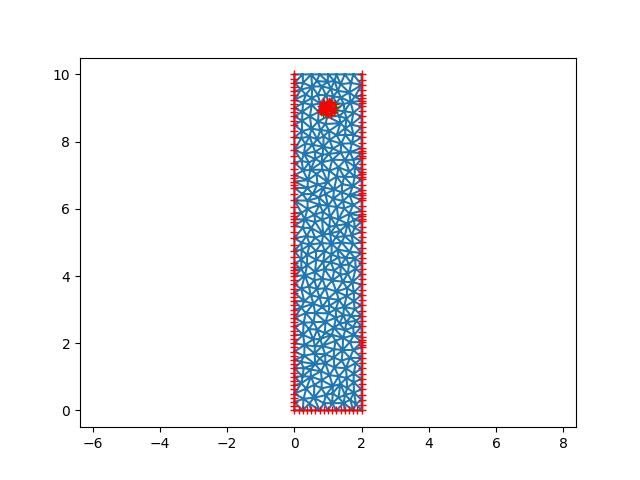

DOF: 3007


In [42]:
mx = 1.
my = 9.
eps = 1e-7

vertices = np.array([[0., 0], [2, 0], [2, 10], [0, 10]])
mesh = finis.triangulate(vertices=vertices, max_area=0.05)
fe_u = finis.fe_space(mesh, order=2, order_int=2)
fe_p = finis.fe_space(mesh, order=1, order_int=2)
finis.plot_mesh(mesh, fig=plt.figure())

if True:
    markers = fe_u['markers']
    free_upper_boundary = True

    if free_upper_boundary:
        markers = np.logical_and(markers, np.logical_or(fe_u['dof'][:,1] < 10.0, np.logical_or(fe_u['dof'][:,0] == 0, fe_u['dof'][:,0] == 2)))
    plt.plot(fe_u['dof'][markers==1,0], fe_u['dof'][markers==1,1], 'r+')
    plt.axis("equal")
    
inside_dof = (fe_u['dof'][:,0]-mx)**2 + (fe_u['dof'][:,1]-my)**2 <= 0.25**2
plt.plot(fe_u['dof'][inside_dof,0], fe_u['dof'][inside_dof,1], 'g+')

inside_integ = (fe_u['integ'][:,0]-mx)**2 + (fe_u['integ'][:,1]-my)**2 <= 0.25**2
plt.plot(fe_u['integ'][inside_integ,0], fe_u['integ'][inside_integ,1], 'r+')


assert np.array_equal(fe_u['integ'], fe_p['integ']), "FE Spaces not compatible"
assert np.array_equal(fe_u['w'], fe_p['w']), "FE integration weights not compatible"

print("DOF: {}".format(fe_u['dof'].shape[0]*2 + fe_p['dof'].shape[0]))

In [19]:
dim_u = fe_u['dof'].shape[0]
dim_p = fe_p['dof'].shape[0]

assert np.array_equal(fe_u['integ'], fe_p['integ']), "FE Spaces not compatible"
assert np.array_equal(fe_u['w'], fe_p['w']), "FE integration weights not compatible"

# Free upper boundary
markers = fe_u['markers']
h_bnd = np.logical_or(fe_u['dof'][:,0] == 0, fe_u['dof'][:,0] == 2)
not_top_bnd = fe_u['dof'][:,1] < 10.0
markers = np.logical_and(markers, np.logical_or(h_bnd, not_top_bnd))

min_dist = min([mx, 2-mx, my, 10-my])

# Setting up system
f1 = lambda x,y: np.zeros_like(x)
inside = lambda x,y: ((x-mx)**2 + (y-my)**2 <= 0.25**2).astype(np.float)
_rho = 16.0 / np.pi - 1
f2 = lambda x,y: -9.81*np.ones_like(x)*(1. + _rho*inside(x,y))

# Particular solution
UP1 = np.zeros((dim_u, ))
UP2 = np.zeros((dim_u, ))
UHP = np.concatenate((UP1, UP2, np.zeros((dim_p, ))))        

# Construct non-dirichlet RHS
W = sp.spdiags([fe_u['w']], [0], m=fe_u['w'].size, n=fe_u['w'].size)
A11 = fe_u['DUX'].transpose().dot(W).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W).dot(fe_u['DUY'])
A22 = A11
A12 = fe_u['DUY'].transpose().dot(W).dot(fe_u['DUX'])
A21 = A12.transpose()
A13 = -fe_u['DUX'].transpose().dot(W).dot(fe_p['U'])
A23 = -fe_u['DUY'].transpose().dot(W).dot(fe_p['U'])

# Question 13 Regularizer
#P_inside = sp.csr_matrix(sp.diags([inside_dof.astype(np.float32)], offsets=[0]))
#A_inside = (1/eps) * P_inside.transpose().dot(A11).dot(P_inside)
w_inside = np.copy(fe_u['w'])
w_inside[np.logical_not(inside_integ)] = 0.0
assert fe_u['w'].shape == w_inside.shape
assert np.allclose(np.sum(fe_u['w'][inside_integ]), np.sum(w_inside)), "Must have same sum"
W_inside = sp.spdiags([w_inside], [0], m=w_inside.size, n=w_inside.size)
A_inside = (1./eps)*(fe_u['DUX'].transpose().dot(W_inside).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W_inside).dot(fe_u['DUY']))
A12i = (1./eps)*(fe_u['DUY'].transpose().dot(W_inside).dot(fe_u['DUX']))
A21i = (1./eps)*(fe_u['DUX'].transpose().dot(W_inside).dot(fe_u['DUY']))
A_test  = sp.bmat([[A_inside, A12i, None], [A21i, A_inside, None], [None, None, sp.coo_matrix((dim_p, dim_p))]], format='csr')
assert np.allclose((A_test - A_test.transpose()).data / np.amax(np.abs(A_test.data)), 0), "A_test is not numerically symmetric!"
print("Mean A test           {}".format(np.mean(A_test.data)))

A = sp.bmat([[A11, A12, A13], [A21, A22, A23], [A13.transpose(), A23.transpose(), None]], format='csr')
assert np.allclose((A - A.transpose()).data / np.amax(np.abs(A.data)), 0), "A is not numerically symmetric!"

# Construct non-dirichlet LHS
F1int = f1(fe_u['integ'][:,0], fe_u['integ'][:,1])
F2int = f2(fe_u['integ'][:,0], fe_u['integ'][:,1])

_F1 = np.concatenate((
    fe_u['U'].transpose().dot(W).dot(F1int),
    fe_u['U'].transpose().dot(W).dot(F2int),
    np.zeros(dim_p, )
))
F = _F1 - A.dot(UHP)

# Apply dirichlet boundary
row = np.where(markers==0)[0]
col = np.arange(row.size)
data = np.ones((row.size, ), dtype=np.float)
P_u = sp.csr_matrix((data, (row, col)), shape=(markers.size, row.size))
dim_ud = P_u.shape[1]
P = sp.bmat([[P_u, None, None], [None, P_u, None], [None, None, sp.eye(dim_p)]], format='csr')
Ad = P.transpose().dot(A).dot(P)
assert np.allclose((Ad - Ad.transpose()).data / np.amax(np.abs(Ad.data)), 0), "Ad is not numerically symmetric!"
Fd = P.transpose().dot(F)

A_test_d = P.transpose().dot(A_test).dot(P)
print("Mean A test dirichlet {}".format(np.mean(A_test_d.data)))

# Solve
x = sp.linalg.spsolve(Ad + A_test_d, Fd)
# x[2*dim_ud:] -= np.mean(x[2*dim_ud:]) # remove mean pressure

# Transform back (Dirichlet)
u_h = P.dot(x) + UHP
u1_h = u_h[0:dim_u]
u2_h = u_h[dim_u:2*dim_u]
p_h = u_h[2*dim_u:]
assert p_h.size == dim_p

# Calculate Viscos force
# Fb_x = sp.bmat([[A11], [A21], [A13.transpose()]], format='csr').dot(w_h).dot(u_h)
# Fb_y = sp.bmat([[A12], [A22], [A23.transpose()]], format='csr').dot(w_h).dot(u_h)

print(A_test.dot(u_h).dot(u_h))

Mean A test           3.571706901689275e-12
Mean A test dirichlet 3.214536211520348e-11
4.717129981512969e-06


<IPython.core.display.Javascript object>


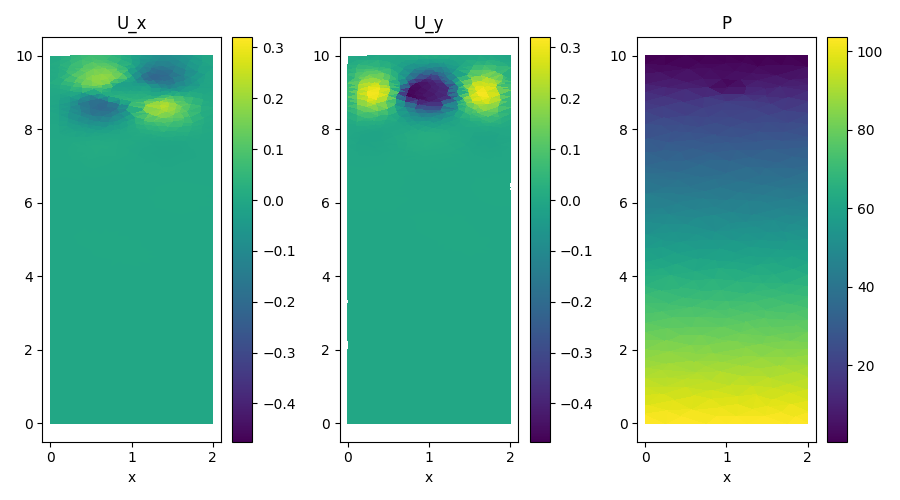

In [43]:
fem_plot(fe_u, fe_p, u1_h, u2_h, p_h)

In [47]:
%%time
fem_rhs(mx=1., my=9., eps=1e-5, debug=True)

eps = 1e-05
CPU times: user 59.7 ms, sys: 11.4 ms, total: 71 ms
Wall time: 68.5 ms


array([ 0.00483037, -0.42404333])

In [53]:
%%time
f = lambda t, y: fem_rhs(mx=y[0], my=y[1], eps=1e-5, debug=True)

tspan = np.array([0., 10])
y0 = np.array([1., 9])

sol = solve_ivp(f, tspan, y0, method='RK45', dense_output=True)
if sol.status < 0:
    print("Failed")
    print(sol.message)
else:
    print("Succeeded in {} steps with {} rhs calls".format(sol.t.size, sol.nfev))

fem rhs: mx = 1.0. my = 9.0
fem rhs: mx = 1.0014416784548101. my = 8.873439475910354
fem rhs: mx = 1.0001905619530487. my = 8.983271151366017
fem rhs: mx = 1.0002810243538511. my = 8.975905938300594
fem rhs: mx = 1.0007660550819013. my = 8.932295105215914
fem rhs: mx = 0.9995203477152625. my = 8.915108479547486
fem rhs: mx = 1.0019231065903136. my = 8.907414897793693
fem rhs: mx = 1.0037351262595198. my = 8.922031903366683
fem rhs: mx = 1.0063532707632497. my = 8.89300628185245
fem rhs: mx = 1.0057745832220144. my = 8.878561905810994
fem rhs: mx = 1.0162550117011793. my = 8.824344405120348
fem rhs: mx = 1.0327858803330674. my = 8.836147130567054
fem rhs: mx = 1.0338789056043904. my = 8.82437715914354
fem rhs: mx = 1.0117120886823472. my = 8.79296098459083
fem rhs: mx = 1.0169159166764683. my = 8.756103454255062
fem rhs: mx = 1.015644594121938. my = 8.741622778770202
fem rhs: mx = 1.0221850983004757. my = 8.594196020149102
fem rhs: mx = 1.0361704377858798. my = 8.460151489357811
fem rhs

<IPython.core.display.Javascript object>


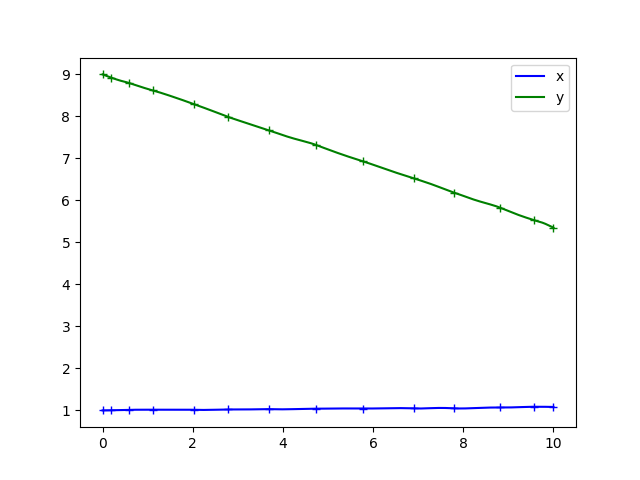

In [54]:
tt = np.linspace(sol.t[0], sol.t[-1], 10000)
Y = sol.sol(tt)
plt.figure()
plt.plot(tt, Y[0,:], 'b-', label='x')
plt.plot(sol.t, sol.y[0,:], 'b+')
plt.plot(tt, Y[1,:], 'g-', label='y')
plt.plot(sol.t, sol.y[1,:], 'g+')
plt.legend()
plt.show()